# GIS and Machine Learning with Python

This workshop is designed to get you familiar with basic GIS and machine learning functionality with a python SW stack. 

By the end of these lessions, you should be able to:
 - Download, explore, and plot from spatial files
 - Do basic manipulations of spatial shapes
 - Perform basic spatial analyses
 - Combine results from a machine learning model with spatial data

This workshop will be done using Jupyter Notebooks and requires the following modules:
     - GIS Modules
            - Geopandas
            - Shapely
            - Pyproj
            - Fiona
            - Geopy
            - Proximity Hash
            - Geohash
            
     - General Purpose Modules
             - Pandas
             - Matplotlib
             - Numpy
             - Pylab
             - Time
             - Sys

In [3]:
import geopandas as gp
from shapely.geometry import Point, LineString, Polygon
import shapely.geometry
import pyproj
from fiona.crs import from_string, to_string
from geopy.geocoders import Nominatim
import proximityhash
# import _geohash

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import sys

# set optional visual parameters for pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
plt.rcParams['image.cmap'] = 'YlGn'


# set optional display parameters for pandas
pd.options.display.max_rows = 6

# Activate Geopy geocoder
geolocator = Nominatim()

## Part 1 - Basic GIS

1.1 Geometry

Geography is underlaid by geometrical shapes. When working with the geo-tools, we'll be dealing with 3 main elements: points, lines, and polygons. In this first section, we'll practice creating, analyzing and manipulating these elements.

2D Points

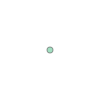

In [23]:

point1 = Point(1.2, 50) 
point2 = Point(5, -42.0)
point3 = Point(-6, 3.5)
point1

In [38]:
print(point1)

POINT (1.2 50)


In [20]:
# 2D Points have a few use methods and attributes including: coordinates, geom_type, distance
point1.x, point1.y, point1.coords.xy

(1.2, 50.0, (array('d', [1.2]), array('d', [50.0])))

In [19]:
# If you ever get confused about what a shapely object is, you can call "geom_type"
point1.geom_type

'Point'

In [22]:
# Given another point, the "distance" method an calclate the distance
point1.distance(point2)

92.078444817449

 LineStrings

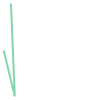

In [24]:

# We can create lines by entering coordinates, or by using points

line1 = LineString([point1, point2, point3])
line1



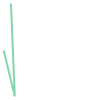

In [27]:
# I can enter the coordinate of our original points and get the same result

line2 = LineString([(1.2, 50), (5, -42.0), (-6, 3.5)])
line2

In [28]:
print(line1)

LINESTRING (1.2 50, 5 -42, -6 3.5)


In [29]:
line1.geom_type

'LineString'

In [31]:
# the 'centroid' method
print(line1.centroid)

POINT (1.886667356320875 -3.836106657094351)


In [33]:
# the "boundary" method
print(line1.boundary)

MULTIPOINT (1.2 50, -6 3.5)


In [35]:
# the 'length' attribute
line1.length

138.88923417204117

In [37]:
# We can also get the x & y coordinates of the line
line1.xy

(array('d', [1.2, 5.0, -6.0]), array('d', [50.0, -42.0, 3.5]))

Polygons

We can create polygons from points (by using their coordinates), or by inputing coordinates.

Using the previously generated points....

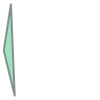

In [40]:
# Create polygon from coordinates

poly1 = Polygon([(1.2, 50), (5, -42.0), (-6, 3.5)])
poly1

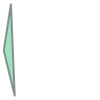

In [44]:
# Using something similar to a list comprehension, we can also generate the polygon using the coordinates of points

poly2 = Polygon([[point.x, point.y] for point in [point1, point2, point3]])
poly2

In [45]:
print(poly1)

POLYGON ((1.2 50, 5 -42, -6 3.5, 1.2 50))


Like maps objects, for instance continents with lakes or bodies of water with islands, polygons can have one or more holes inside of them.

In [62]:
larger_shape = [(-200, 100), (-200, -100), (200, -100), (200, 100)]
hole = [[(-150, 50), (-150, -50), (150, -50), (150, 50)]]
rect1 = Polygon(shell=larger_shape)
rect_with_hole = Polygon(shell=larger_shape, holes=hole)

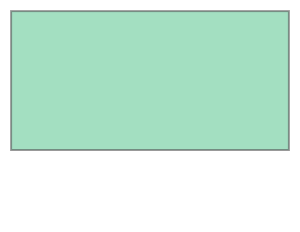

In [63]:
rect1

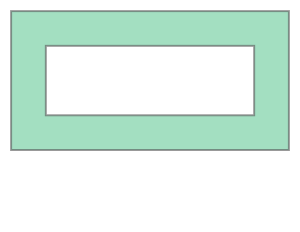

In [64]:
rect_with_hole

In [61]:
# Notice the printout of this shape has two sets of tuples in enclosed parentheses, one for the surrounding object, 
# and one for the hole

print(rect_with_hole)

POLYGON ((-200 100, -200 -100, 200 -100, 200 100, -200 100), (-150 50, -150 -50, 150 -50, 150 50, -150 50))


1.2 Downloading Shapefiles and Performing data exploration

GeoPandas allows import and inspection of geo-spatial files, such as shapefiles.

In this section, we'll download a file and do some basic inspection of it. Let's examine police precincts in Minneapolis.

I got the below file "Minneapolis_Police_Precincts.shp" from: http://opendata.minneapolismn.gov/datasets/minneapolis-police-precincts?geometry=-180%2C-88.438%2C180%2C88.438 . Many government agencies, from very the very local (school districts and townships) to the national and international (USA departments, UN agencies), make geospatial data available for free.

When downloading data, make sure you place all of the available files in one location. Even though below, we are loading only the .shp file, every file in its folder is needed for Geopandas to read it.


In [65]:
minne_police_precincts = gp.read_file('../data/Minneapolis_Police_Precincts.shp')

Coordinate Reference Systems: You MUST have the CRS of the geospatial data. When such data is published, it is expected that the CRS is included. But this is not guaranteed. If you don't have or can't find it, try contacting the agency that published the information. Or try to find the reference systems for maps published by agencies in the same region.

We can use the "crs" attribute to discover the CRS. But NOT ALL shapefiles contain this information.

Why is this information important? If you are going to do more than rudimentary manipulation of your data, a CRS could be crucial. Data that describes information in the same physical location may be published in different reference systems. One example I've found in my work:
    - Shapefiles describing the city boundaries
    - Locations of post addresses
    - Locations of crime events
In this example, all 3 instances of data were in a different CRS. Without normalizing this data to one system, doing analysis or basic plotting would be impossible.

In [67]:
minne_police_precincts.crs


{'init': 'epsg:4326'}

In [68]:
minne_police_precincts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
OBJECTID      5 non-null int64
PRECINCT      5 non-null object
Shape_STAr    5 non-null float64
Shape_STLe    5 non-null float64
geometry      5 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 280.0+ bytes


In [69]:
minne_police_precincts.describe()

,OBJECTID,Shape_STAr,Shape_STLe
count,5.000000,5.000000e+00,5.000000
mean,3.000000,3.202794e+08,84753.135627
std,1.581139,1.371562e+08,21750.347715
...,...,...,...
50%,3.000000,3.515368e+08,89658.738146
75%,4.000000,3.842519e+08,93920.868746
max,5.000000,4.616245e+08,103520.755021


In [70]:
minne_police_precincts.head()

,OBJECTID,PRECINCT,Shape_STAr,Shape_STLe,geometry
0,1,1,9.659868e+07,47205.536504,"POLYGON ((-93.27211391203549 44.9921313598964,..."
1,2,2,3.515368e+08,89459.779720,"POLYGON ((-93.22685080614011 45.0132165472863,..."
2,3,3,4.616245e+08,103520.755021,"POLYGON ((-93.2504437423931 44.9663370085168, ..."
3,4,4,3.073853e+08,93920.868746,"POLYGON ((-93.31949186501051 45.0512462469094,..."
4,5,5,3.842519e+08,89658.738146,"POLYGON ((-93.287640885683 44.969659207443, -9..."


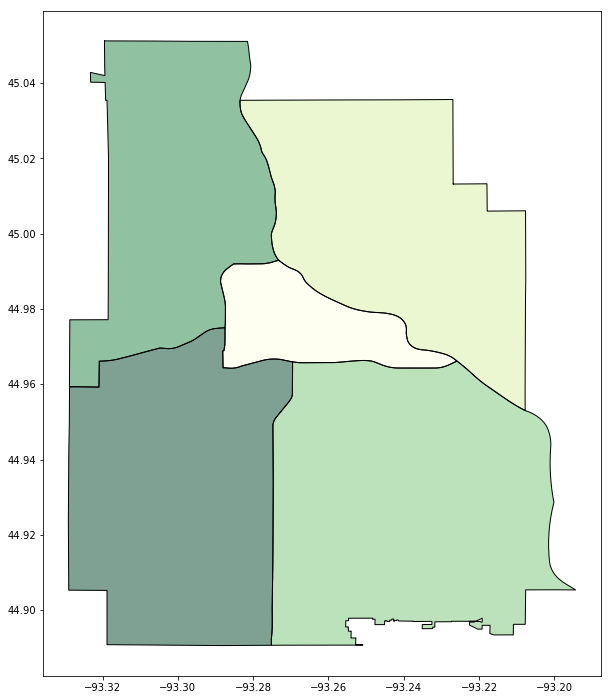

In [71]:
minne_police_precincts.plot()